In [1]:
'''
%%writefile gap.py
start = time.time()
end = time.time()
print(end-start)
'''
import tensorflow as tf
import tensorflow_probability as tfp
import time
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sn
import os as os
import sys
from pathlib import Path

mhsdir = Path(os.getcwd()).parent
sys.path.append(os.path.join(mhsdir, 'src'))

import ns
import gap

datarawdir = os.path.join(mhsdir, 'data\\raw\\YC')
dataprepdir = os.path.join(mhsdir, 'data\\preprocessed')
dataprepnsdir = os.path.join(mhsdir, 'data\\preprocessed\\ns')
datafinaldir = os.path.join(mhsdir, 'data\\concatenated')

tempdatarawdir = os.path.join(mhsdir, 'temp\\data\\raw\\YC')
tempdataprepdir = os.path.join(mhsdir, 'temp\\data\\preprocessed')
tempdataprepnsdir = os.path.join(mhsdir, 'temp\\data\\preprocessed\\ns')

tfd = tfp.distributions
tfpl = tfp.layers
tfk = tf.keras
tfkl = tf.keras.layers
tfb = tfp.bijectors

#!pip install -q requests
import requests
import json
import tempfile
modeldir = os.path.join(mhsdir, 'models')

In C:\Users\PLDD\Anaconda3\envs\tf\lib\site-packages\matplotlib\mpl-data\stylelib\_classic_test.mplstyle: 
The text.latex.preview rcparam was deprecated in Matplotlib 3.3 and will be removed two minor releases later.
In C:\Users\PLDD\Anaconda3\envs\tf\lib\site-packages\matplotlib\mpl-data\stylelib\_classic_test.mplstyle: 
The mathtext.fallback_to_cm rcparam was deprecated in Matplotlib 3.3 and will be removed two minor releases later.
In C:\Users\PLDD\Anaconda3\envs\tf\lib\site-packages\matplotlib\mpl-data\stylelib\_classic_test.mplstyle: Support for setting the 'mathtext.fallback_to_cm' rcParam is deprecated since 3.3 and will be removed two minor releases later; use 'mathtext.fallback : 'cm' instead.
In C:\Users\PLDD\Anaconda3\envs\tf\lib\site-packages\matplotlib\mpl-data\stylelib\_classic_test.mplstyle: 
The validate_bool_maybe_none function was deprecated in Matplotlib 3.3 and will be removed two minor releases later.
In C:\Users\PLDD\Anaconda3\envs\tf\lib\site-packages\matplotlib\

# Autoregressive model

In [3]:
'''
for filename in os.listdir(datafinaldir):
    df = pd.read_csv(os.path.join(datafinaldir, filename))
    newfilename = 'i' + filename
    df.to_csv(os.path.join(datafinaldir, newfilename))
'''

In [14]:
model = tfk.Sequential([
    # NOTE: This model takes no input and outputs a Distribution.  (We use
    # the batch_size and type of the input, but there are no actual input
    # values because the last dimension of the shape is 0.)
    #
    # For conditional density estimation, the model would take the
    # conditioning values as input.)
    tfk.layers.InputLayer(input_shape=(0,), dtype=tf.float32),

    # Given the empty input, return a standard normal distribution with
    # matching batch_shape and event_shape of [2].
    tfpl.DistributionLambda(lambda t: tfd.MultivariateNormalDiag(
        
        loc=tf.zeros(tf.concat([tf.shape(t)[:-1], [4]], axis=0)),
        scale_diag=[1., 1., 1., 1.])),

    # Transform the standard normal distribution with event_shape of [2] to
    # the target distribution with event_shape of [2].
    tfpl.AutoregressiveTransform(tfb.AutoregressiveNetwork(
        params=2, hidden_units=[10], activation='relu')),
])

model.compile(
    optimizer=tfk.optimizers.Adam(),
    loss=lambda y, rv_y: -rv_y.log_prob(y))

In [16]:
y

<tf.Tensor: shape=(294089, 4), dtype=float64, numpy=
array([[ 5.14304261e+01,  1.36461396e+01,  1.30047078e+01,
         1.15823083e+01],
       [ 2.73605199e+01,  3.83893226e+00,  2.34706031e-01,
        -5.14820196e+00],
       [ 9.29931817e+01,  1.90852879e+00,  1.02728592e-01,
         4.99925326e+00],
       ...,
       [ 7.68429665e+01,  5.15692185e+00,  1.44728552e+00,
         1.68377660e+00],
       [ 2.78453206e+00,  8.28409241e+00,  6.78569792e+00,
         4.81817530e+00],
       [ 6.03391404e+01,  2.23000620e+00,  1.00000000e-05,
        -4.40702440e+00]])>

In [15]:
y = iter(gap.make_dataset(dataprepnsdir, eps = 0.00001).batch(640000).take(1)).next()
x = np.zeros((y.shape[0], 0))
hist = model.fit(x=x,
          y=y,
          batch_size=64,
          epochs=2,
          verbose=True)

Epoch 1/2
4596/4596 [==============================] - 7s 1ms/step - loss: nan
Epoch 2/2
4596/4596 [==============================] - 7s 1ms/step - loss: nan


In [ ]:
# Use the fitted distribution.
distribution = model(np.zeros((0,)))
distribution.sample(4)
distribution.log_prob(np.zeros((5, 3, 2)))

# Generate data from GAP and Autoregressive

In [6]:
model_gap = tf.keras.models.load_model("ES4_GW32_GD4_DW32_DD4_BS64/generator")
model_autoreg = model(np.zeros((0,)))

In [7]:
ActTerms = ['D1', 'M01', 'M03', 'M04', 'M06', 'M07', 'M09', 
            'Y01', 'Y02', 'Y03', 'Y04', 'Y05', 'Y06', 'Y07', 'Y08', 'Y09', 'Y10', 'Y12', 'Y15', 'Y20', 'Y30']

@tf.function
def transform_to_yc(x):
    terms = tf.constant([[0.033333, 1.0, 3.0, 4.0, 6.0, 7.0, 9.0,
                          12.0, 24.0, 36.0, 48.0, 60.0, 72.0, 84.0, 96.0, 108.0, 120.0, 144.0, 180.0, 240.0, 360.0, 600.]],dtype = tf.float32)   
    batch = tf.shape(x)[0]
    sz = tf.constant(terms.shape[1])
    val1 = tf.divide(terms, tf.slice(x, [0,0], [batch,1]))
    val2 = tf.math.exp(-val1)
    val3 = tf.divide(1.0 - val2, val1)
    y = tf.add(tf.concat([tf.ones([batch,sz,1]), tf.zeros([batch,sz,1]), tf.expand_dims(-val2, 2)], axis = -1),
               tf.math.multiply(tf.expand_dims(val3, 2), [[-1.0, 1.0, 1.0]]))
    return  tf.einsum('...ik,...k->...i',y, tf.slice(x, [0 , 1],[batch, 3]))

def generate_param_gap(model, cnt, thau_min = 10.0, thau_max = 150.0, max_dev = -0.1): 
    x = tf.repeat(tf.constant([[0.0, 1.0]]), cnt, axis = 0)
    mm = model(x, training=False).numpy()
    lx = (mm[:,0] > thau_min) & (mm[:,0] < thau_max) 
    mm = mm[lx]
    yy = transform_to_yc(mm).numpy()
    max_y = np.max(yy, axis = 1) 
    deviation = (yy[:,-1] - max_y) / max_y
    yy = yy[deviation > max_dev]
    return yy[:, :-1]

def generate_param_autoregressive(model, cnt, thau_min = 10.0, thau_max = 150.0, max_dev = -0.1): 
    mm = model.sample(cnt).numpy()
    lx = (mm[:,0] > thau_min) & (mm[:,0] < thau_max) & (mm[:,1] > 0.0001) & (mm[:,2] > 0.0001)
    mm = mm[lx]
    yy = transform_to_yc(mm).numpy()
    max_y = np.max(yy, axis = 1) 
    deviation = (yy[:,-1] - max_y) / max_y
    yy = yy[deviation > max_dev]
    return yy[:, :-1]

def plot_net(ym):
    x = np.array([0.033333, 1.0, 3.0, 4.0, 6.0, 7.0, 9.0,12.0, 24.0, 36.0, 48.0, 60.0, 72.0, 84.0, 96.0, 108.0,
                  120.0, 144.0, 180.0, 240.0, 360.0])
    num_components =64
    fig = plt.figure(figsize = (16,16))
    fig.subplots_adjust(hspace=0.4, wspace=0.4)

    for i in range(num_components):
        y = ym[i,:]
        ax = fig.add_subplot(8,8,1+i)
        ax.plot(x, y)

In [5]:
ym_gap = generate_param_gap(model = model_gap, cnt = 64000 * 4, thau_min = 10.0, thau_max = 150.0, max_dev = -0.1)
ym_autreg = generate_param_autoregressive(model = model_autoreg, cnt = 64000 * 4, thau_min = 10.0, thau_max = 150.0, max_dev = -0.1)
df1 = pd.DataFrame( data = ym_gap, columns = ActTerms)
df2 = pd.DataFrame(data = ym_autreg, columns = ActTerms)
df = df1.append(df2)
for _ in range(100):
    df = df.sample(frac=1).reset_index(drop=True)

NameError: name 'model_gap' is not defined

In [ ]:
df.to_csv(os.path.join(dataprepnsdir, 'Generated_Total_225492.csv'), index = False)

IndexError: index 63 is out of bounds for axis 0 with size 63

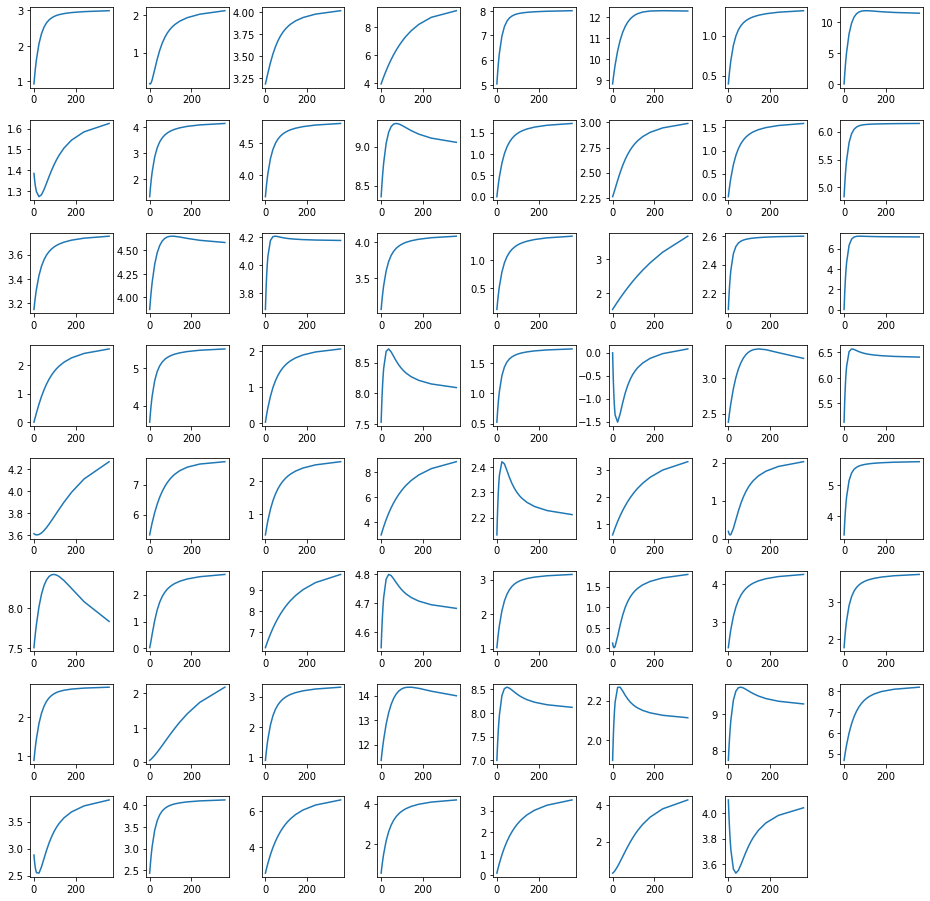

In [10]:
ym_gap = generate_param_gap(model = model_gap, cnt = 164, thau_min = 10.0, thau_max = 150.0, max_dev = -0.1)
plot_net(ym_gap)

In [9]:
ym_autreg = generate_param_autoregressive(model = model_autoreg, cnt = 164, thau_min = 10.0, thau_max = 150.0, max_dev = -0.1)
plot_net(ym_autreg)

C:\Users\PLDD\Anaconda3\envs\tf\lib\site-packages\ipykernel_launcher.py:30: RuntimeWarning: invalid value encountered in greater
C:\Users\PLDD\Anaconda3\envs\tf\lib\site-packages\ipykernel_launcher.py:30: RuntimeWarning: invalid value encountered in less


IndexError: index 0 is out of bounds for axis 0 with size 0

<Figure size 1152x1152 with 0 Axes>